# **Predicted Investment Opportunities for the Syracuse Real Estate Investment Trust**
The purpose of this lab is to predict 2018 housing valuesand the best zip codes for investment based on 1996-2017 data. 

## Load Required Packages

In [1]:
# pip install pmdarima

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # show all results for cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import datetime as dt
from statsmodels.tsa.stattools import adfuller # stationarity test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
# from statsmodels.tsa.api import ARMA as arma
# from statsmodels.tsa.arima.model.ARIMA import ARIMA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## **Data & Cleaning** 
The following data sets were utilized in this analysis.
    
##### **Single Family Residence Values 1996 - 2020**
* Source: Zillow  
* Location: files.zillowstatic.com/research/public/Zip/* Zip_Zhvi_SingleFamilyResidence.csv  
* Filename: Zip_Zhvi_SingleFamilyResidence.csv

##### **Prices for Single Family Homes Under Construction by month from 1964 - 2016**
* Source: US Census Bureau Data  
* Location: https://data.world/uscensusbureau/construction-price-indexes/workspace/file?filename=price_uc_cust.xls   
* Filenames: 
  *   PriceUnderConstruction1964-2016.csv (by month)
  *   PriceUnderConstructionByYear64-16.csv (by year)

##### **SOI Tax Stats - Individual Income Tax Statistics - 2018 ZIP Code Data (SOI)**
* Source: Internal Revenue Service  
* Location: https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2018-zip-code-data-soi
* Filename: ReturnsByZip2018.csv

## Load Data

In [3]:
zip = pd.read_csv('Zip_Zhvi_SingleFamilyResidence.csv')
ucm = pd.read_csv('PriceUnderConstruction1964-2016.csv')
ucy = pd.read_csv('PriceUnderConstructionByYear64-16.csv')
tax18 = pd.read_csv('ReturnsByZip2018.csv')
tax19 = pd.read_csv('ReturnsByZip2019.csv')

## Clean Data
### Tax Data

In [4]:
tax18['Year'] = '01/01/2018'
tax19['Year'] = '01/01/2019'
tax2018 = tax18[['Year', 'STATE', 'zipcode', 'Returns', 'SingleReturns', 'JointReturns', 'HOHReturns', 'NoIndividuals', 'AGI', 'SalNWagesAmt', 'HomeInterestPaid', 'TaxableIncomeAmt']]
tax2019 = tax19[['Year', 'STATE', 'zipcode', 'Returns', 'SingleReturns', 'JointReturns', 'HOHReturns', 'NoIndividuals', 'AGI', 'SalNWagesAmt', 'HomeInterestPaid', 'TaxableIncomeAmt']]
tax = pd.concat([tax2018, tax2019])

### Under Construction Data

In [5]:
ucy.columns=['Year', 'Annual Index']

# convert Date column to date format
ucy['Year'] = pd.to_datetime(ucy['Year'], format='%m/%d/%Y')
ucm['Date'] = pd.to_datetime(ucm['Date'], format='%m/%d/%Y')

# set to date indices
ucy = ucy.set_index(pd.DatetimeIndex(ucy['Year']))
ucm = ucm.set_index(pd.DatetimeIndex(ucm['Date']))
ucy = ucy.drop('Year', axis=1)
ucm = ucm.drop('Date', axis=1)

### Clean Zip Data 

In [6]:
mzip = zip.melt(id_vars=["RegionID", "SizeRank", "RegionName", "RegionType", "StateName", "State", "City", "Metro", "CountyName"], var_name="Date", value_name="Value")

# remove rows with nulls
mzip = mzip.dropna()

## **Explore**

In [7]:
df = mzip.groupby('Date').mean()
df = df.drop(['RegionID', 'SizeRank', 'RegionName'], axis=1 )
df.index = pd.to_datetime(df.index)
px.line(df, title='Zillow Average Single Family Residence Values 1996 - 2020')

# **ASSIGNMENT QUESTION**
* Integrate data from other sources  

#### Visualize Under Construction Data

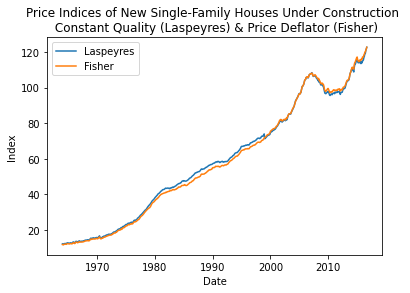

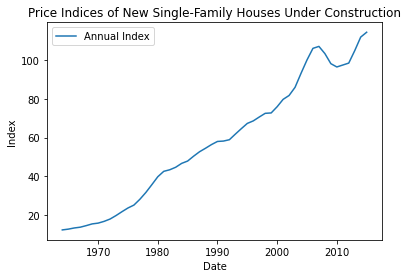

In [8]:
plt.plot(ucm['Laspeyres (Fixed)'], label = 'Laspeyres')
plt.plot(ucm['Fisher (Deflator)'] , label = 'Fisher')
plt.title('Price Indices of New Single‐Family Houses Under Construction \n Constant Quality (Laspeyres) & Price Deflator (Fisher)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Index')
plt.show();
plt.plot(ucy, label = 'Annual Index')
plt.title('Price Indices of New Single‐Family Houses Under Construction')
plt.xlabel('Date')
plt.ylabel('Index')
plt.legend()
plt.show();

## **Taxes by State**

In [9]:
px.bar(tax, x="STATE", y="TaxableIncomeAmt", title='Taxes by State')

### Clean & extract specified Arizona metro data 



In [10]:
ar = mzip.loc[mzip['Metro'].isin(['Fayetteville-Springdale-Rogers', 'Hot Springs', 'Little Rock-North Little Rock-Conway', 'Searcy'])]
ar.loc[ar.Metro=="Little Rock-North Little Rock-Conway", "Metro"] = "Little Rock Metro"
ar.loc[ar.Metro=='Fayetteville-Springdale-Rogers', "Metro"] = "Fayetteville Metro"
# ar.head(1)

In [11]:
# Turn ar into time series
ar=ar.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName'], 1)
ar.columns = ['ZipCode', 'State', 'City', 'Metro', 'CountyName', 'Date', 'Value']
ar=ar.set_index(pd.DatetimeIndex(ar['Date']))
ar=ar.drop(['Date'], 1)
# ar.head(2)

In [12]:
# Take Averages by Metro Area
FMetro = ar[ar['Metro']=='Fayetteville Metro']
HSMetro = ar[ar['Metro']=='Hot Springs']
LRMetro = ar[ar['Metro']=='Little Rock Metro']
SMetro = ar[ar['Metro']=='Searcy']

ar = ar.groupby(['Date','Metro'])['Value'].mean()
ar.columns = ['Date', 'Metro', 'Value']
ar = ar.to_frame()
# ar.head(2)

FMetro = FMetro.groupby(['Date'])['Value'].mean().to_frame()
HSMetro = HSMetro.groupby(['Date'])['Value'].mean().to_frame()
LRMetro = LRMetro.groupby(['Date'])['Value'].mean().to_frame()
SMetro = SMetro.groupby(['Date'])['Value'].mean().to_frame()

# **ASSIGNMENT QUESTION**
# Visualize Average Single Family Residence Value  
## Arkansas Metro Areas - Individually
---


Text(0.5, 1.0, 'Fayetteville Metro')

Text(0.5, 1.0, 'Hot Springs')

Text(0.5, 1.0, 'Little Rock Metro')

Text(0.5, 1.0, 'Searcy')

Text(0.5, 0.04, '\n \n \n \n Date')

Text(0.06, 0.5, 'Value \n \n \n \n \n')

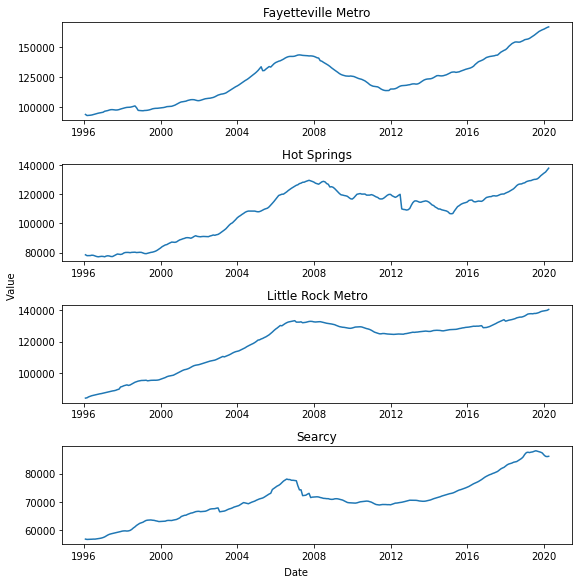

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8,8))

ax1.set_title('Fayetteville Metro')
ax1.plot(FMetro)
ax2.set_ylabel=('Value')
ax2.plot(HSMetro)
ax2.set_title('Hot Springs')
ax3.plot(LRMetro)
ax3.set_title('Little Rock Metro')
ax4.plot(SMetro)
ax4.set_title('Searcy')
ax4.set_ylabel=('Date')

fig.tight_layout()

# Set common labels
fig.text(0.5, 0.04, '\n \n \n \n Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Value \n \n \n \n \n', ha='center', va='center', rotation='vertical')


# **ASSIGNMENT QUESTION**
## Single Family Residence Values
## Arkansas Metro Areas - Combined
---

Text(0.5, 1.0, 'Zillow Single Family Residence Value Over Time\n By Arkansas Metro Area')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Value')

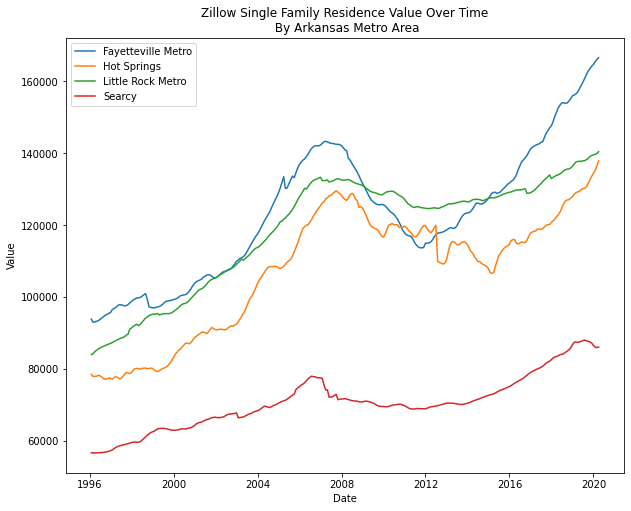

In [14]:
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(FMetro, label = "Fayetteville Metro")
plt.plot(HSMetro, label = "Hot Springs")
plt.plot(LRMetro, label='Little Rock Metro')
plt.plot(SMetro, label='Searcy')
plt.title("Zillow Single Family Residence Value Over Time\n By Arkansas Metro Area")
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()
plt.show()

## Monthly Time Series Decomposition
Series decomposition shows trend and seasonality as would be expected of the housing market from a monthly perspective.

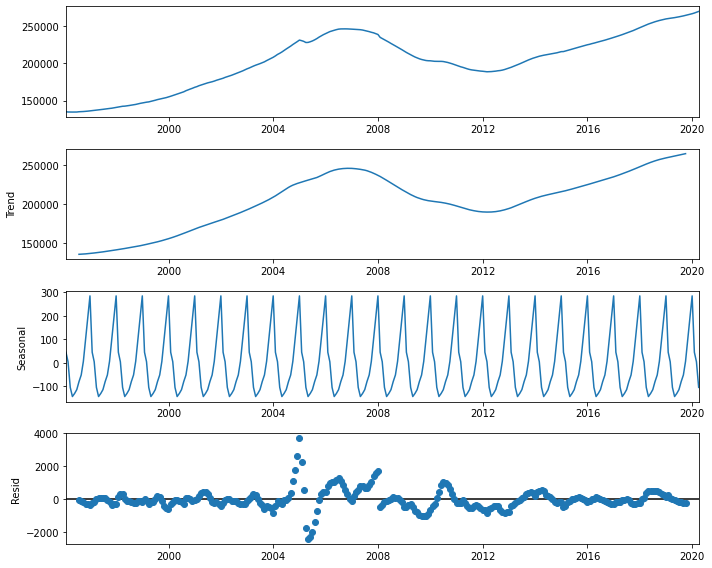

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = sm.tsa.seasonal_decompose(df,  model = 'additive')
fig = decomposition.plot()
plt.show()

## Annual Time Series Decomposition
Series decomposition shows trend but not seasonality, as would be expected looking at the data by year.  
  
*Ultimately not used for modeling*

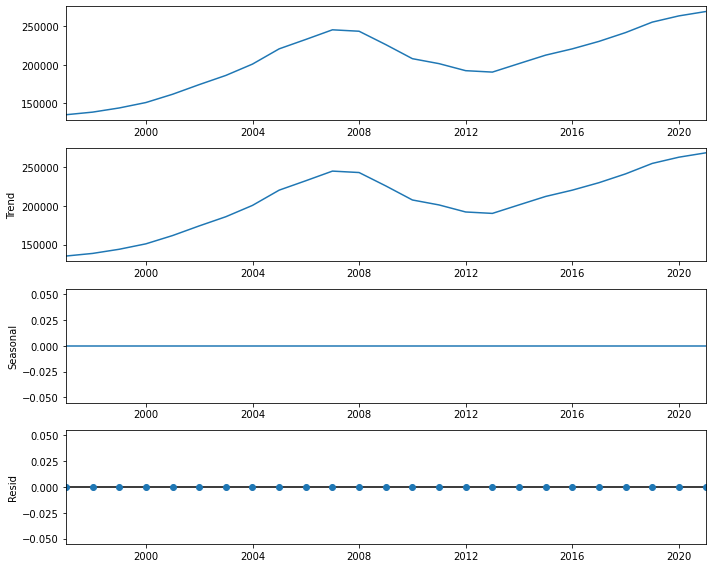

In [16]:
ts = df.resample('A').mean()
decomposition = sm.tsa.seasonal_decompose(ts, model = 'additive')
fig = decomposition.plot()
plt.show()

## ADFuller Stationarity Test
Using monthly data instead of annual

In [17]:
adftest = adfuller(df['Value'])
print('p-Value of ADFuller Test is ', adftest[1])

p-Value of ADFuller Test is  0.5826854564974981


In [18]:
result = adfuller(df['Value'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.399146
p-value: 0.582685
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


# **ASSIGNMENT QUESTION**
* Develop model(s) for foracasting average median housing value byzip code for 2018
* Use the histoprical data form 1997 - 2017 as training data

## Divide into Training and Test Sets
### Training Data

In [19]:
df3 = df[:276]
train = df3[:264]

## Test Data

In [20]:
test = df3[264:]

# Determine p,d,q for ARIMA

In [21]:
import itertools
import statsmodels.api as sm
p=range(0,8)
q=range(0,8)
d=range(0,2)
pdq_combination=list(itertools.product(p,d,q))

In [22]:
rmse=[]
order1=[]

for pdq in pdq_combination:
  try:
    model=sm.tsa.arima.ARIMA(train, order=pdq).fit()
    pred=model.predict(start=len(train), end=(len(df3)-1))
    error=np.sqrt(mean_squared_error(test, pred))
    order1.append(pdq)
    rmse.append(error)
  except:
    continue

In [23]:
results = pd.DataFrame(index=order1, data=rmse, columns=['RMSE'])
results.to_csv('ARMIA_Result.csv')
#results.head()

# Build ARIMA Model

In [24]:
model = sm.tsa.arima.ARIMA(train, order=(7,0,6)).fit() 

# Predict Test Data Set

In [25]:
pred=model.predict(start=len(train), end=(len(df3)-1))

# Model Evaluation

In [26]:
error = np.sqrt(mean_squared_error(test, pred))
error

553.9499683282497

Error is within a single standard deviation

In [27]:
test.mean(), np.sqrt(test.var()) # std 

(Value    255244.261375
 dtype: float64, Value    3507.188661
 dtype: float64)

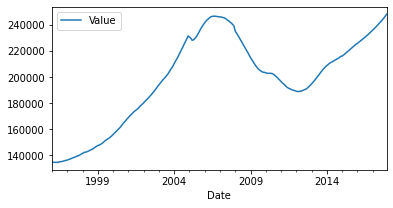

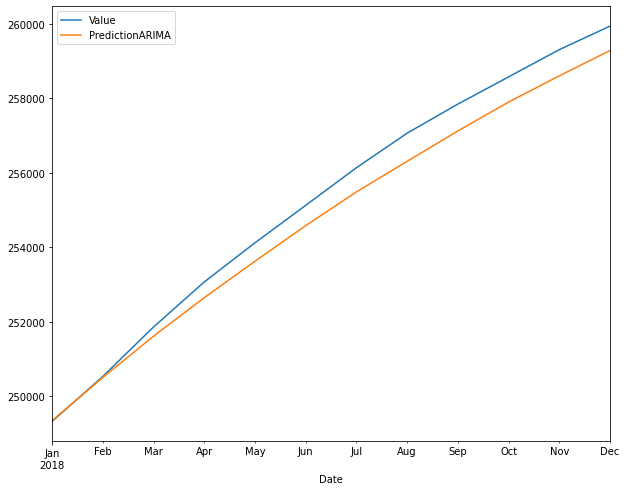

In [28]:
train.plot(legend=True, label='Train', figsize=(6,3))
test.plot(legend=True, label='Test')
pred.plot(legend=True, label='PredictionARIMA')

# Predict Future Data

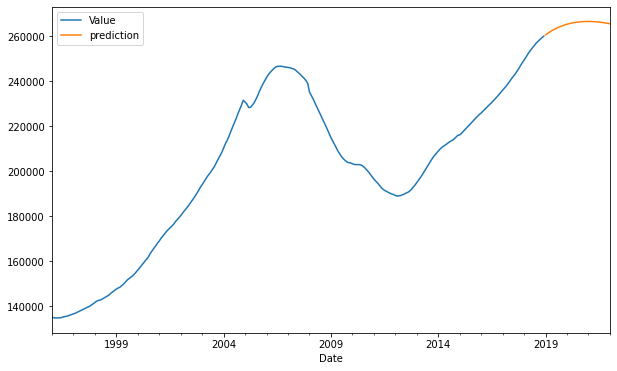

In [29]:
final_model = sm.tsa.arima.ARIMA(df3, order=(7,0,6)).fit()
prediction=final_model.predict(len(df3), len(df3)+36)
df3.plot(legend=True, label='Train', figsize=(10,6))
prediction.plot(legend=True, label='prediction')

### Determine P On The Annual Data To See How Many Years Impact Next Measurement

In [30]:
# Training & Test Sets
train = ts[:23]
test = ts[23:]

p=range(0,8)
q=range(0,8)
d=range(0,2)
pdq_combination=list(itertools.product(p,d,q))
rmse=[]
order1=[]

for pdq in pdq_combination:
  try:
    model=sm.tsa.arima.ARIMA(train, order=pdq).fit()
    pred=model.predict(start=len(train), end=(len(ts)-1))
    error=np.sqrt(mean_squared_error(test, pred))
    order1.append(pdq)
    rmse.append(error)
  except:
    continue

results = pd.DataFrame(index=order1, data=rmse, columns=['RMSE'])
results.to_csv('ARMIA_TS.csv')


Optimal PDQ = 7, so 7 years prior impact next year. Will take Top 100 ZipCodes with Highest % Chg from 2010 - 2017 to examing for possible best investments. 

## Identify Top 100 ZipCodes by % Chg

In [31]:
m2 = mzip[['RegionName', 'Date', 'Value']]
m2.columns = ['ZipCode', 'Date', 'Value']
m2['Growth'] = m2['Value'].diff(periods=84)
m2.set_index(pd.DatetimeIndex(m2['Date']), inplace=True)
m3 = m2[m2.index.year==2017]
m3 = m3[m3.index.month==12]
m3['PctChg'] = m3['Growth']/(m3['Value'] - m3['Growth'])
m3.head(1)

,ZipCode,Date,Value,Growth,PctChg
Date,,,,,
2017-12-31,10025,2017-12-31,1508495.0,1460603.0,30.497849


In [32]:
m3.to_csv('Chg2010-2017.csv')

In [33]:
zdf = mzip[['Date', 'RegionName', 'Value']]
zdf.set_index(['RegionName', 'Date'], inplace=True)
zdf.sort_index(inplace=True)

In [34]:
zdf.dropna(inplace=True)
g = zdf.reset_index()
g = g[['Date', 'RegionName', 'Value']]
g['ZipCode']= g['RegionName'].apply(str)

Drop the first year Growth where no data from previous year

In [35]:
g.set_index(pd.DatetimeIndex(g['Date']), inplace=True)
g.drop(['RegionName'], axis=1, inplace=True)

Remove growth values from data points with no previous date range values.

In [36]:
h = g.groupby('ZipCode').apply(lambda group: group.iloc[1:,1:])

In [39]:
h.drop('ZipCode', axis=1, inplace=True)
h = h.reset_index()
h.head()

,ZipCode,Date,Value
0,10001,1996-02-29,284673.0
1,10001,1996-03-31,285884.0
2,10001,1996-04-30,292432.0
3,10001,1996-05-31,295610.0
4,10001,1996-06-30,301629.0


## Isolate Top 100 Zip Codes by Growth

In [40]:
t10 = h.loc[h['ZipCode'].isin(['11968','33149','2445','10011','94027','10075','92663','11962','94109','95837'
, '94957','2112','94022','92657','11217','81611','93108','94010','2459','83011','11976','11201','10025','33160','95030'
,'97009','94950','94528','94305','2906','11965','94920','2108','10028','92067','11930','81656','96790','92091','93101'
,'11568','81615','83353','21056','90402','11975','94028','92625','10023','94618','6807','95514','94903','92059','10013'
,'94556','90265','1772','10805','2576','89413','4006','31561','10128','95439','43021','33449','80302','92007','11231'
,'94123','81657','90272','92130','7043','49117','33154','94301','10021','95121','2368','95661','7030','90077','10002'
,'92661','10030','94129','95746','6831','6390','94131','90067','10533','2807','29941','60657','19017','94404','98220'])]

t10.head(1)

,ZipCode,Date,Value
290,10002,2003-08-31,1468876.0


## Top 100 Zip Codes by Growth Over Time

In [41]:
px.line(t10, x='Date', y='Value', color='ZipCode')

### Extract data through 2017

In [42]:
t10 = t10[t10['Date']<'2018-01-01']

In [43]:
df = pd.DataFrame(['Growth By ZipCode'])
df.to_csv('results.csv')

In [44]:
from csv import writer

In [45]:
d = {}
final_model ={}
prediction = {}
for ZipCode in t10['ZipCode'].unique():
  try:
    d[ZipCode] = t10[t10['ZipCode'] == ZipCode].sort_values(by='Date')
    d[ZipCode] =  d[ZipCode].set_index(pd.DatetimeIndex( d[ZipCode]['Date']))
    d[ZipCode].drop(['ZipCode', 'Date'], axis=1, inplace=True)
    final_model[ZipCode] = sm.tsa.arima.ARIMA(d[ZipCode], order=(7,0,6)).fit()
    prediction[ZipCode]=final_model[ZipCode].predict(len(d[ZipCode]), len(d[ZipCode])+12)
    prediction[ZipCode] = (prediction[ZipCode].diff(periods=12).to_frame())
    prediction[ZipCode] = prediction[ZipCode][prediction[ZipCode]['predicted_mean'].notnull()]
    prediction[ZipCode].name = ZipCode
    prediction[ZipCode].reset_index(inplace=True)
    prediction[ZipCode].drop('index', axis=1, inplace=True)
    z = prediction[ZipCode]['predicted_mean'].values.tolist()
    results = [prediction[ZipCode].name, z[0]]
    with open('results.csv', 'a', newline='') as f_object:  
      writer_object = writer(f_object)
      writer_object.writerow(results)  
      f_object.close()
  except:
    continue

27

26

26

27

27

26

27

26

26

26

26

25

27

26

26

27

26

27

27

26

26

26

25

27

26

25

26

25

24

25

25

24

25

27

26

26

26

27

26

25

27

26

25

25

26

26

25

26

25

26

25

25

27

26

26

26

26

26

26

26

25

25

26

25

25

26

26

26

25

25

26

25

26

25

25

26

26

25

26

26

24

25

24

26

26

26

26

26

27

25

25

25

25

27

27

26

25

27

25

27

# Top 5 Zip Codes by Growth

In [46]:
g.drop('Date', axis=1, inplace=True)

In [47]:
g10 = g[g['ZipCode'].isin(['90402', '94027','90272','90077','90265'])]
g10.reset_index(inplace=True)

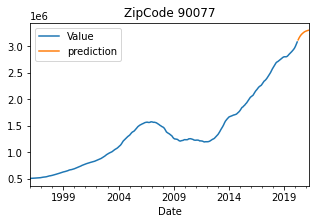

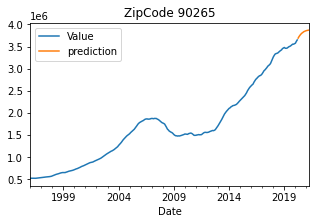

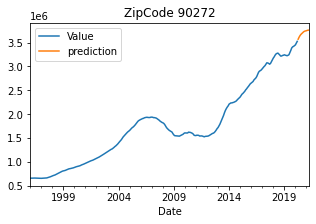

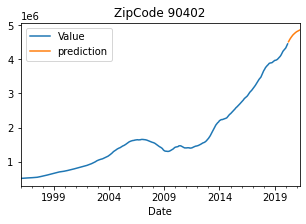

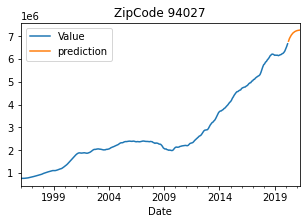

In [48]:
d = {}
for ZipCode in g10['ZipCode'].unique():
  d[ZipCode] = g10[g10['ZipCode'] == ZipCode].sort_values(by='Date')
  d[ZipCode] =  d[ZipCode].set_index(pd.DatetimeIndex( d[ZipCode]['Date']))
  d[ZipCode].drop(['ZipCode', 'Date'], axis=1, inplace=True)
  final_model[ZipCode] = sm.tsa.arima.ARIMA(d[ZipCode], order=(7,0,6)).fit()
  prediction[ZipCode]=final_model[ZipCode].predict(len(d[ZipCode]), len(d[ZipCode])+12)
  d[ZipCode].plot(legend=True, label='Train', title=('ZipCode ' + ZipCode), figsize=(5,3))
  prediction[ZipCode].plot(legend=True, label='prediction')
    

# **ASSIGNMENT QUESTIONS**
**What technique/algorithm/decision process did you use to down sample? (BONUS FOR NOT DOWN SAMPLING)**

No down sampling was performed for the modeling or final results. The December values for each year were subset and a difference of the value from 12 months prior was used to evaluate the data growth by year without resampling. 

**What three zip codes provide the best investment opportunity for the SREIT? Why?**  
  Predictions were generated for each zip code using a model built from the 1996 - 2017 data. The predicted mean amount in 2018 minus the actual amount in 2017 was used to identify total predicted growth per zip code. This was compared to identify Zip Codes:  
  * **90402** as the highest profitable zip code with \$423,033  precicted growth in 2018
  * **94027** as the second highest profitable zip code with \$266,786 predicted growth in 2018
  * **90272** as the third highest profitable zip code with \$215,080 predicted growth in 2018